In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import f1_score,classification_report,confusion_matrix,auc,roc_auc_score,roc_curve
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

In [206]:
# Cargar el archivo train.csv desde la carpeta "data"
df_train = pd.read_csv("D:/proyectoICSPM/data/train.csv")
df_test = pd.read_csv("D:/proyectoICSPM/data/test.csv")
df_sub = pd.read_csv("D:/proyectoICSPM/data/sample_submission.csv")

In [207]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [208]:
df_train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [209]:
category_data = df_train[['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage','Response','Driving_License']]
continuous_data = df_train[['Age','Annual_Premium','Vintage']]

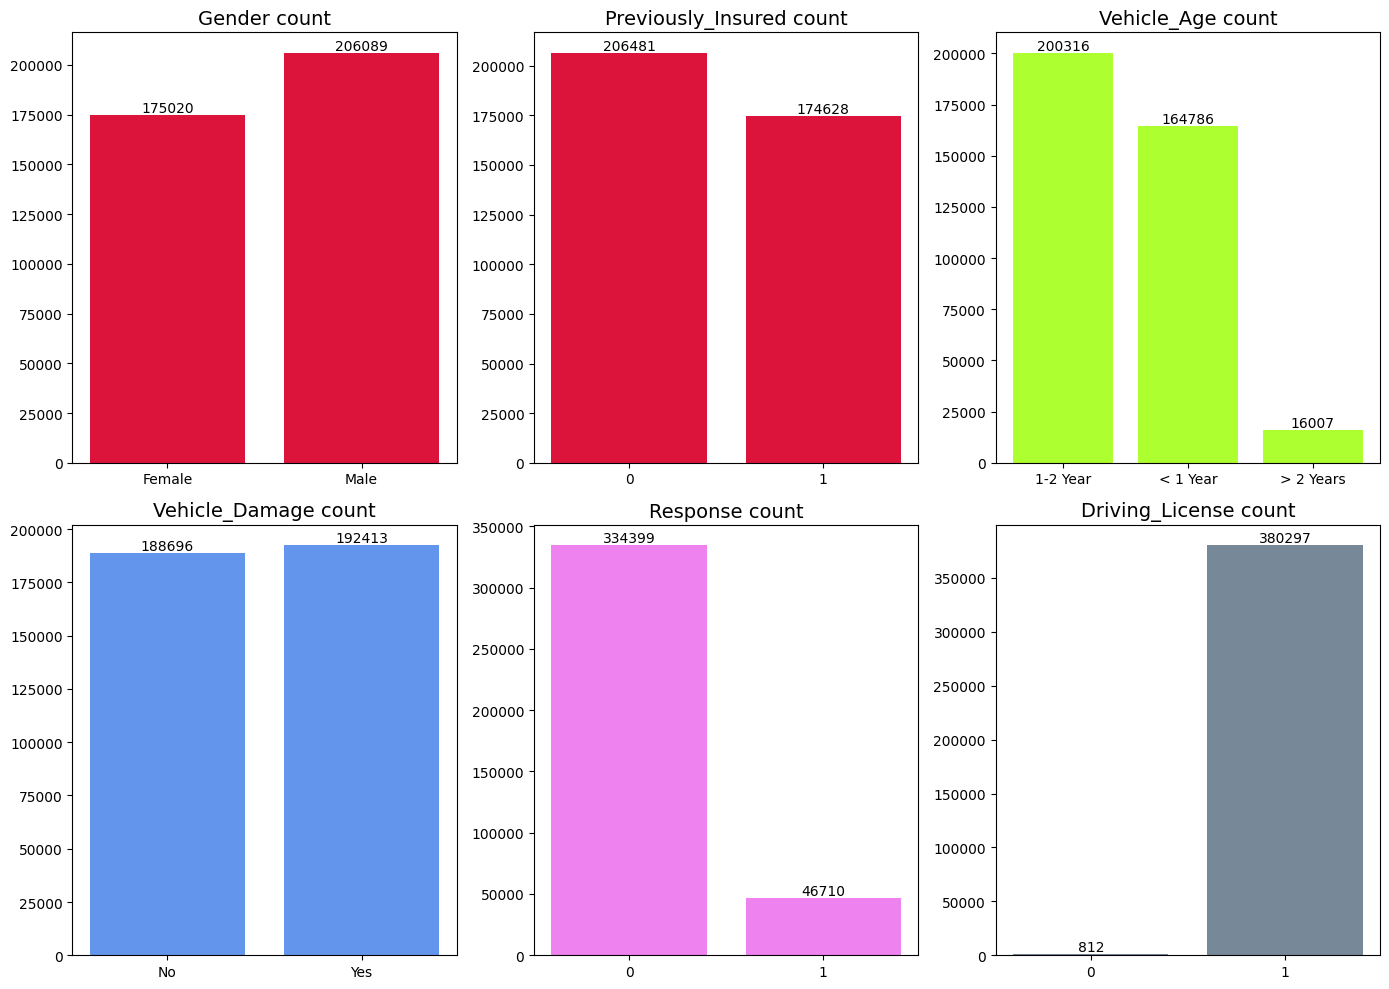

In [171]:
plt.figure(figsize=(14,10))
color_ls = ['#DC143C','#DC143C','#ADFF2F','#6495ED','#EE82EE','#778899']
for i in range(6):
    plt.subplot(2,3,i + 1)
    plt.title(category_data.columns[i] + ' count',fontsize=14)
    col_count = category_data[category_data.columns[i]].value_counts().sort_index()
    plt.bar(col_count.index,col_count.values,color=color_ls[i])
    plt.xticks(col_count.index)
    for i in range(len(col_count)):
        plt.text(i,col_count.values[i],str(col_count.values[i]),va='bottom',ha='center')
plt.tight_layout()
plt.show()

In [210]:
continuous_data.describe()

,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


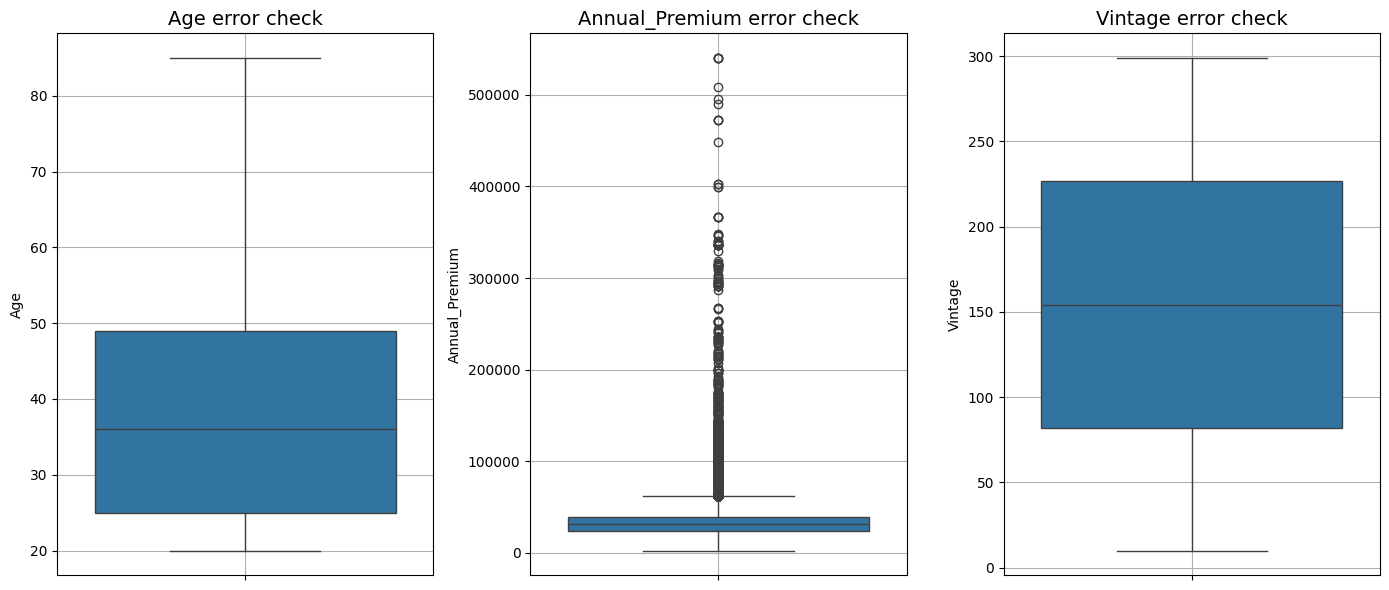

In [173]:
fig,ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    sns.boxplot(continuous_data[continuous_data.columns[i]],ax=ax[i])
    ax[i].set_title(continuous_data.columns[i] + ' error check',fontsize=14)
    ax[i].grid()
plt.tight_layout()
plt.show()

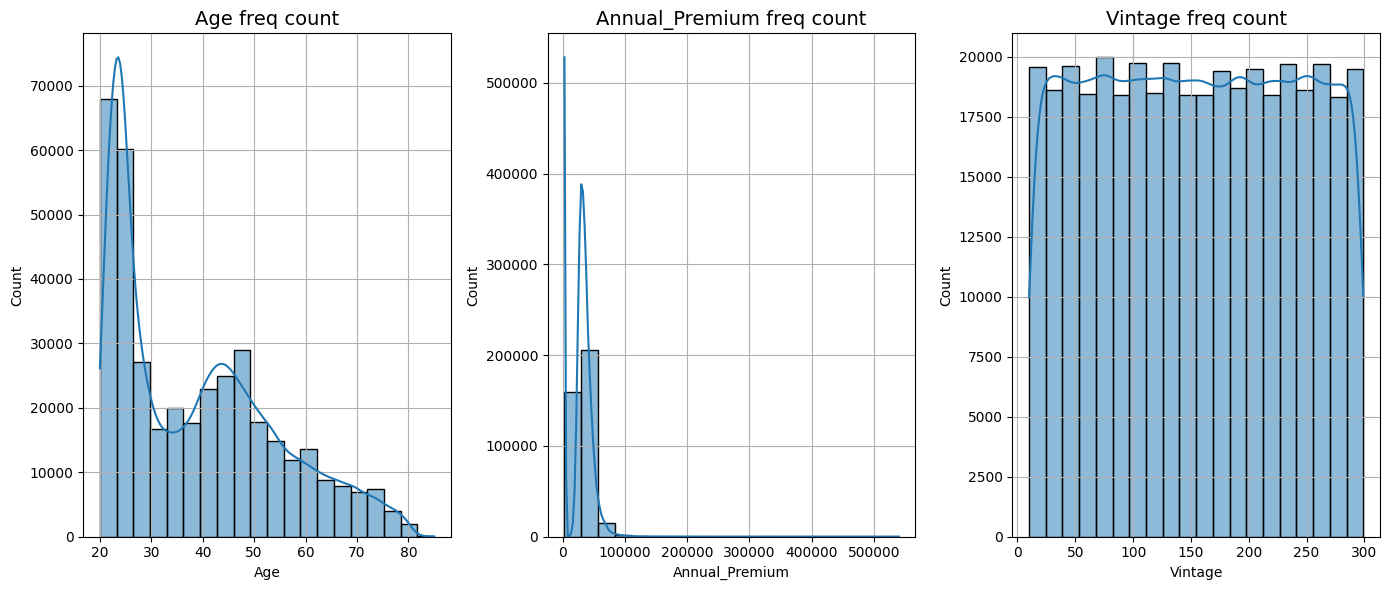

In [174]:
fig,ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    sns.histplot(continuous_data[continuous_data.columns[i]],ax=ax[i],kde=True,bins=20)
    ax[i].set_title(continuous_data.columns[i] + ' freq count',fontsize=14)
    ax[i].grid()
plt.tight_layout()
plt.show()

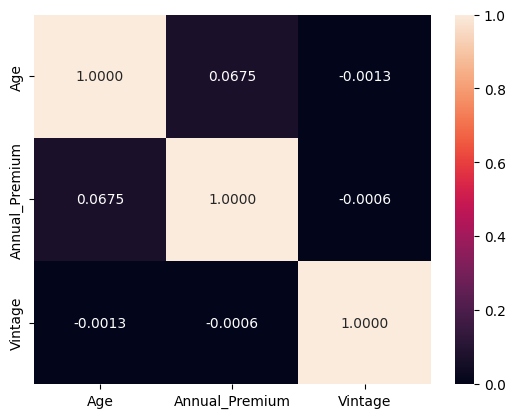

In [175]:
sns.heatmap(continuous_data.corr(),annot=True,fmt='.4f')
plt.show()

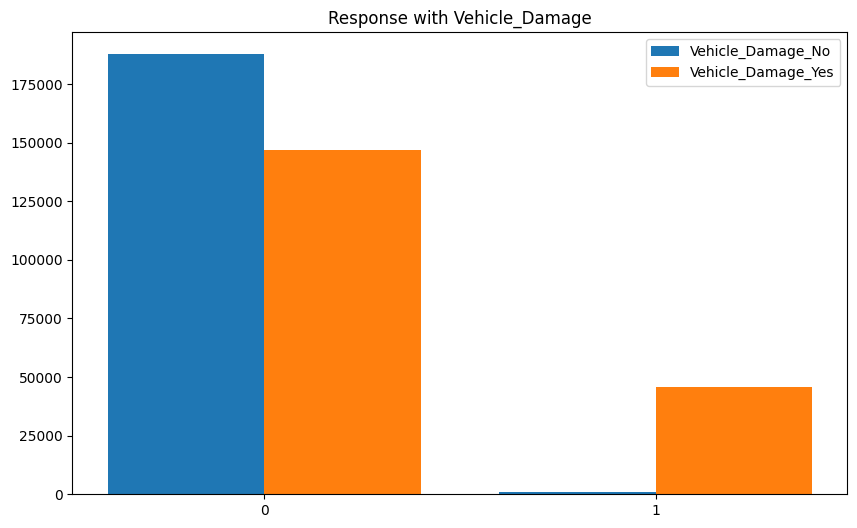

In [177]:
is_damage = df_train.groupby(['Vehicle_Damage','Response']).agg({"id":'count'}).rename({'id':'Count'},axis=1).reset_index()
no_damage = is_damage[is_damage['Vehicle_Damage'] == 'No']
yes_damage = is_damage[is_damage['Vehicle_Damage'] == 'Yes']
plt.figure(figsize=(10,6))
plt.bar(no_damage['Response'] - 0.20,no_damage['Count'],width=0.4,label='Vehicle_Damage_No')
plt.bar(yes_damage['Response'] + 0.20,yes_damage['Count'],width=0.4,label='Vehicle_Damage_Yes')
plt.xticks(yes_damage['Response'])
plt.title('Response with Vehicle_Damage')
plt.legend()
plt.show()

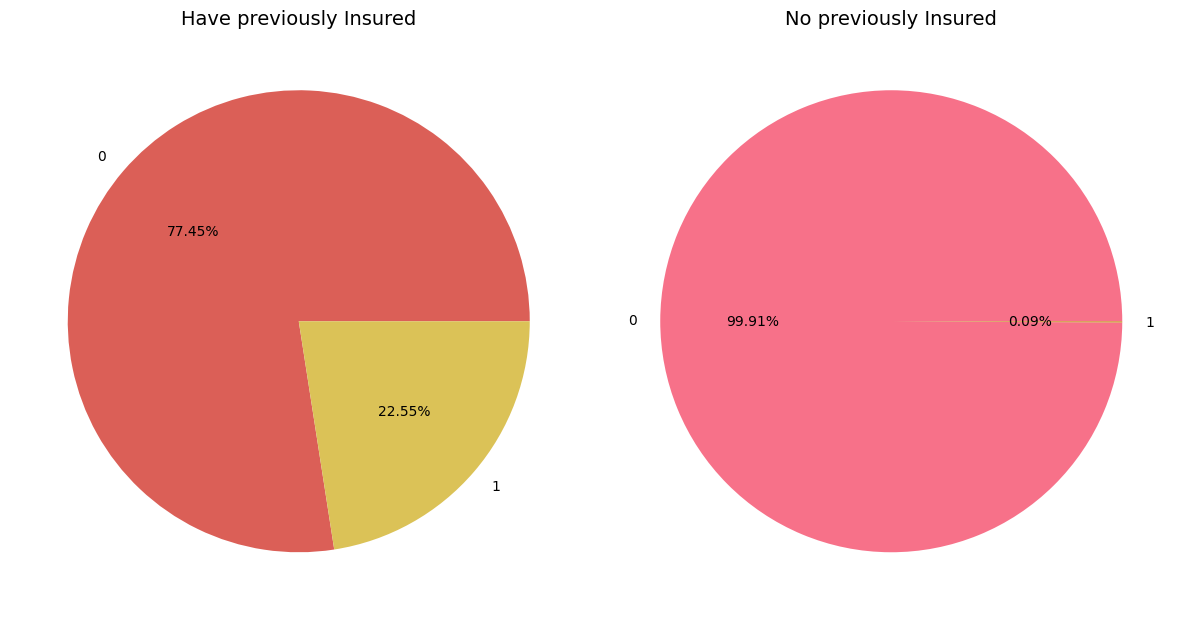

In [178]:
is_prev = df_train.groupby(['Previously_Insured','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
prev = is_prev[is_prev['Previously_Insured'] == 0]
no_prev = is_prev[is_prev['Previously_Insured'] == 1]
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pie(prev['Count'],labels=prev['Response'],autopct='%.2f%%',colors=sns.color_palette("hls", 8))
plt.title('Have previously Insured',fontsize=14)

plt.subplot(1,2,2)
plt.pie(no_prev['Count'],labels=no_prev['Response'],autopct='%.2f%%',colors=sns.color_palette("husl", 8))
plt.title('No previously Insured',fontsize=14)

plt.tight_layout()
plt.show()

In [211]:
indicate_region = pd.DataFrame()
for i in df_train['Region_Code'].value_counts().iloc[:8].index:
    indicate_region = pd.concat([indicate_region,df_train[df_train['Region_Code'] == i]])

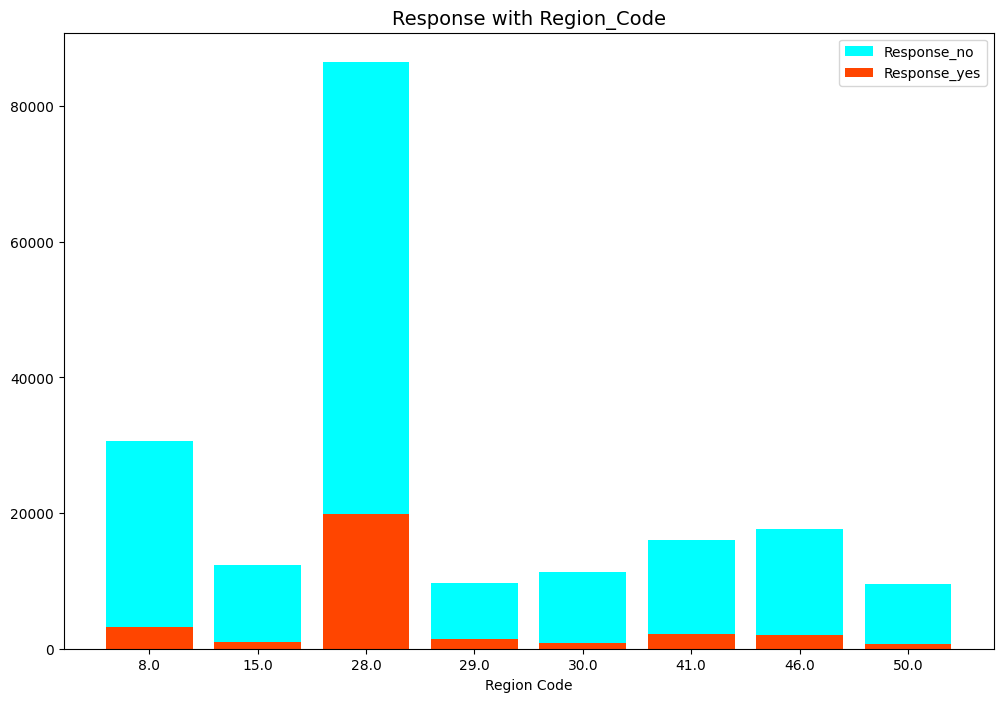

In [180]:
region_response = indicate_region.groupby(['Region_Code','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
no_response = region_response[region_response['Response'] == 0]
yes_response = region_response[region_response['Response'] == 1]
plt.figure(figsize=(12,8))
plt.bar(no_response['Region_Code'].astype('str'),no_response['Count'],color='#00FFFF',label='Response_no')
plt.bar(yes_response['Region_Code'].astype('str'),yes_response['Count'],color='#FF4500',label='Response_yes')
plt.title('Response with Region_Code',fontsize=14)
plt.xlabel('Region Code')
plt.legend()
plt.show()

In [212]:
des_data = df_train['Vintage'].describe()
def level_func(x):
    if x >= des_data['75%']:
        return 'high'
    elif x > des_data['50%'] and x < des_data['75%']:
        return 'mid'
    else:
        return 'low'
df_train['customer_level'] = df_train['Vintage'].apply(level_func)

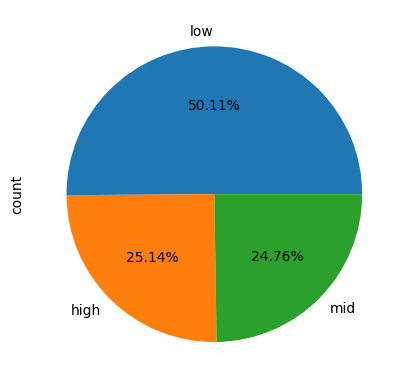

In [182]:
df_train['customer_level'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

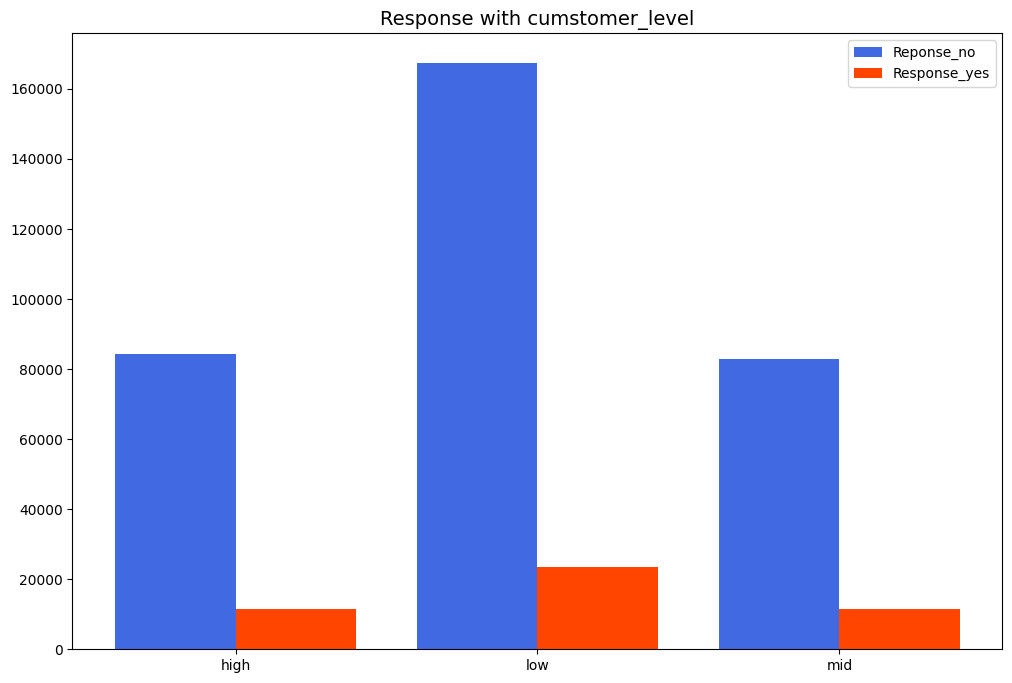

In [183]:
res = df_train.groupby(['customer_level','Response']).agg({'id':'count'}).rename({'id':'Count'},axis=1).reset_index()
no_res = res[res['Response'] == 0]
yes_res = res[res['Response'] == 1]
plt.figure(figsize=(12,8))
plt.bar(np.array(range(len(no_res))) - 0.2,no_res['Count'],width=0.4,label='Reponse_no',color='#4169E1')
plt.bar(np.array(range(len(yes_res))) + 0.2,yes_res['Count'],width=0.4,label='Response_yes',color='#FF4500')
plt.xticks(range(len(no_res)),no_res['customer_level'])
plt.title('Response with cumstomer_level',fontsize=14)
plt.legend()
plt.show()

In [213]:
data_features = pd.concat([category_data,continuous_data],axis=1)
data_features['Region_Code'] = df_train['Region_Code']
data_features['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel']

In [214]:
max_min_encoder = MinMaxScaler()
max_min_encoder.fit(data_features[['Age','Annual_Premium','Vintage']])

MinMaxScaler()

In [215]:
data_features[['Age','Annual_Premium','Vintage']] = max_min_encoder.transform(data_features[['Age','Annual_Premium','Vintage']])

In [216]:
from imblearn.over_sampling import SMOTE
import re

# 1. Separar features y target
X = data_features.drop('Response', axis=1)
Y = data_features['Response']

# 2. One-hot encoding conservando todas las categorías
X = pd.get_dummies(X, drop_first=False)

# 3. Renombrar columnas para evitar errores con caracteres especiales (<, >, espacios, etc.)
X.columns = [re.sub(r'[^\w]', '_', str(col)) for col in X.columns]

# 4. Balancear con SMOTE
stome = SMOTE(sampling_strategy=1.0, random_state=7)
X, Y = stome.fit_resample(X, Y)

# 5. Dividir en train y test
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=Y)

# 6. Asegurar que test_x tenga las mismas columnas (por si acaso)
test_x = test_x.reindex(columns=train_x.columns, fill_value=0)


In [ ]:
X = data_features.drop('Response',axis=1)
Y = data_features['Response']
X = pd.get_dummies(X, drop_first=False)
#stome = SMOTE(sampling_strategy=1.0, random_state=7)
#X,Y = stome.fit_resample(X,Y)
#train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.2,random_state=7,stratify=pd.DataFrame(Y))
# Renombrar columnas para que no haya problemas con caracteres especiales
import re
X.columns = [re.sub(r'[^\w]', '_', str(col)) for col in X.columns]

stome = SMOTE(sampling_strategy=1.0, random_state=7)
X, Y = stome.fit_resample(X, Y)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=Y)


In [217]:
logistic_model = LogisticRegression()
logistic_model.fit(train_x,train_y)

d:\proyectoICSPM\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

              precision    recall  f1-score   support

           0       0.97      0.60      0.74     66880
           1       0.71      0.98      0.82     66880

    accuracy                           0.79    133760
   macro avg       0.84      0.79      0.78    133760
weighted avg       0.84      0.79      0.78    133760

f1 score: 0.8216636031141586 roc auc score: 0.787477571770335


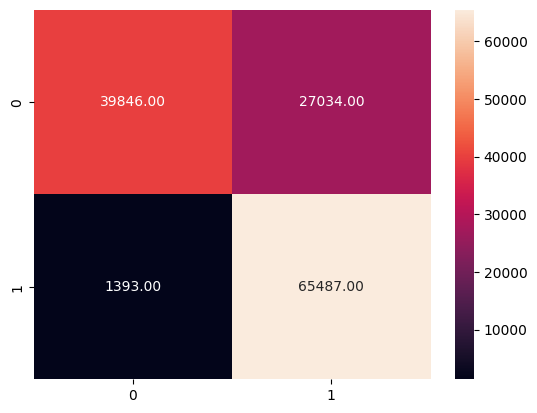

In [189]:
y_pred = logistic_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [218]:
tree_model = DecisionTreeClassifier()
tree_model.fit(train_x,train_y)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     66880
           1       0.88      0.89      0.89     66880

    accuracy                           0.88    133760
   macro avg       0.88      0.88      0.88    133760
weighted avg       0.88      0.88      0.88    133760

f1 score: 0.885901566492612 roc auc score: 0.8848310406698565


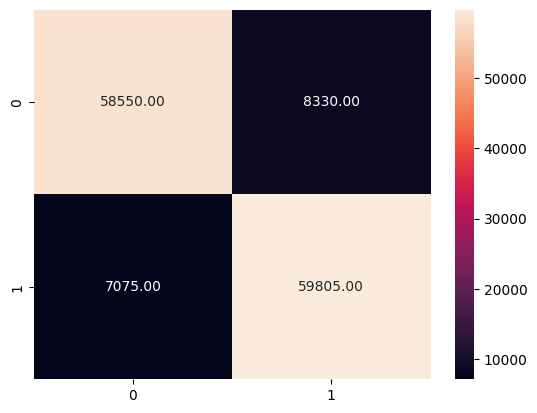

In [191]:
y_pred = tree_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [219]:
gradient_model = GradientBoostingClassifier(n_estimators=50,random_state=7,learning_rate=0.01)
gradient_model.fit(train_x,train_y)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, random_state=7)

              precision    recall  f1-score   support

           0       0.95      0.64      0.76     66880
           1       0.73      0.97      0.83     66880

    accuracy                           0.80    133760
   macro avg       0.84      0.80      0.80    133760
weighted avg       0.84      0.80      0.80    133760

f1 score: 0.8300514412530627 roc auc score: 0.8019138755980861


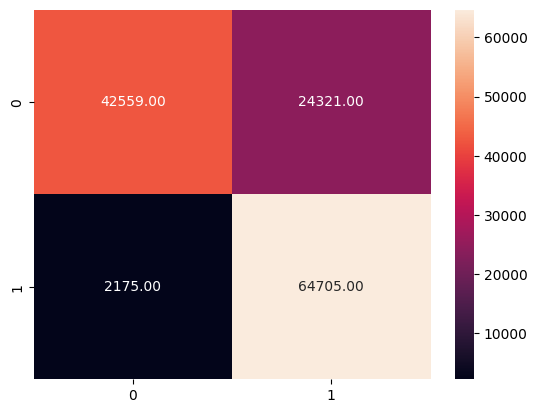

In [193]:
y_pred = gradient_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [220]:
ada_model = AdaBoostClassifier(n_estimators=50,random_state=7,learning_rate=0.01)
ada_model.fit(train_x,train_y)

AdaBoostClassifier(learning_rate=0.01, random_state=7)

              precision    recall  f1-score   support

           0       0.97      0.56      0.71     66880
           1       0.69      0.98      0.81     66880

    accuracy                           0.77    133760
   macro avg       0.83      0.77      0.76    133760
weighted avg       0.83      0.77      0.76    133760

f1 score: 0.813192651255884 roc auc score: 0.7739234449760766


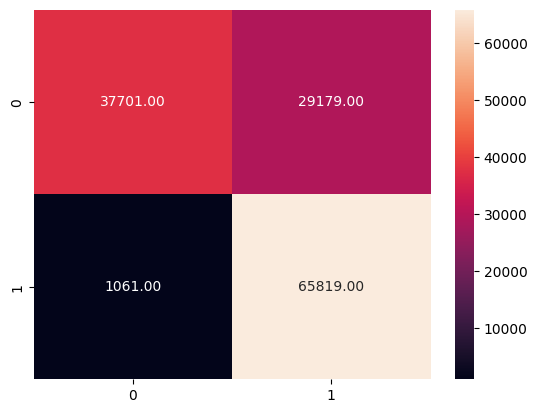

In [195]:
y_pred = ada_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [197]:
#se agrego porque las columnas en train_x contienen caracteres no válidos, como [ o ], y XGBoost no lo permite.
import re
train_x.columns = [re.sub(r'[^\w]', '_', str(col)) for col in train_x.columns]
test_x.columns = [re.sub(r'[^\w]', '_', str(col)) for col in test_x.columns]

In [221]:
xgb_model = xgb.XGBClassifier(learning_rate=0.8,gamma=0.5,max_depth=3)
xgb_model.fit(train_x,train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.8, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     66880
           1       0.81      0.89      0.85     66880

    accuracy                           0.84    133760
   macro avg       0.85      0.84      0.84    133760
weighted avg       0.85      0.84      0.84    133760

f1 score: 0.849587623730671 roc auc score: 0.8419781698564593


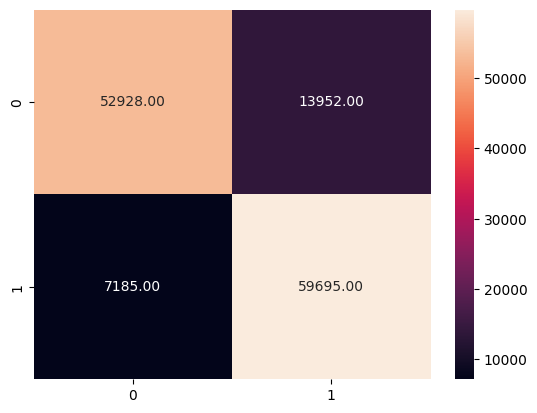

In [199]:
y_pred = xgb_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [222]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.9)
lgb_model.fit(train_x,train_y)

[LightGBM] [Info] Number of positive: 267519, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 535038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.9)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     66880
           1       0.87      0.87      0.87     66880

    accuracy                           0.87    133760
   macro avg       0.87      0.87      0.87    133760
weighted avg       0.87      0.87      0.87    133760

f1 score: 0.8722802078497731 roc auc score: 0.8724730861244019


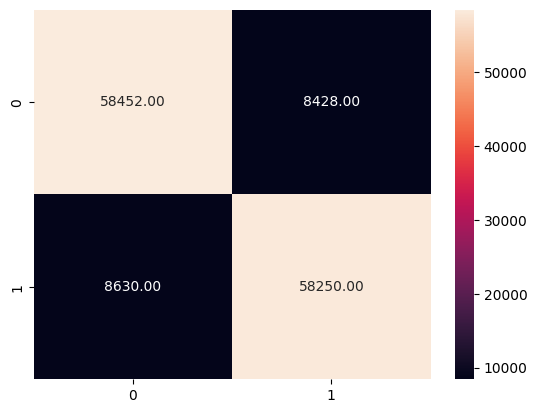

In [201]:
y_pred = lgb_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

In [223]:
randomforest_model = RandomForestClassifier(n_estimators=50,random_state=7,n_jobs=-1)
randomforest_model.fit(train_x,train_y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=7)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     66880
           1       0.86      0.94      0.90     66880

    accuracy                           0.90    133760
   macro avg       0.90      0.90      0.90    133760
weighted avg       0.90      0.90      0.90    133760

f1 score: 0.9011129094633112 roc auc score: 0.8967703349282297


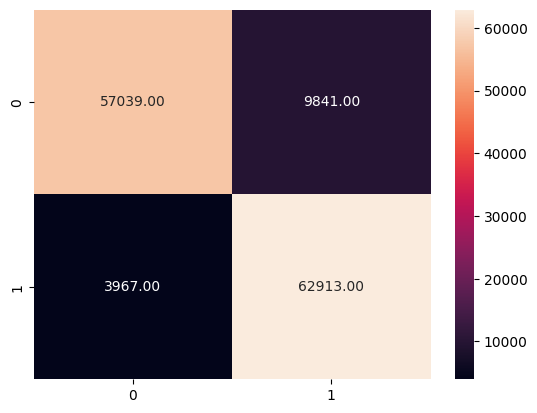

In [203]:
y_pred = randomforest_model.predict(test_x)
print(classification_report(test_y,y_pred))
print('f1 score:',f1_score(test_y,y_pred),'roc auc score:',roc_auc_score(test_y,y_pred))
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,fmt='.2f')
plt.show()

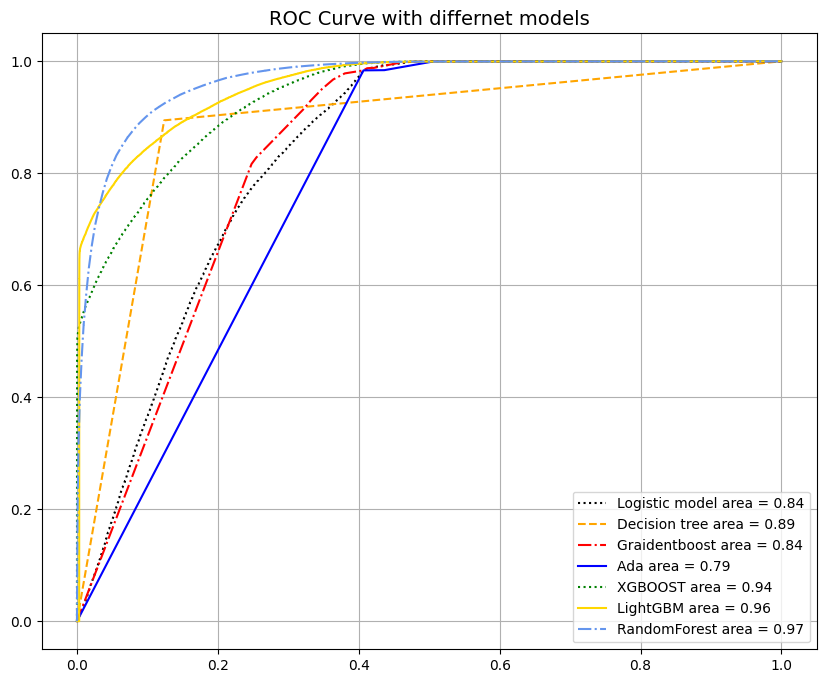

In [224]:
model_ls = [logistic_model,tree_model,gradient_model,ada_model,xgb_model,lgb_model,randomforest_model]
model_name = ['Logistic model','Decision tree','Graidentboost','Ada','XGBOOST','LightGBM','RandomForest']
colors = ['black','orange','red','blue','green','#FFD700','#6495ED']
linestyles = [':','--','-.','-',':','-','-.']
plt.figure(figsize=(10,8))
plt.title('ROC Curve with differnet models',fontsize=14)

test_x = test_x.reindex(columns=train_x.columns, fill_value=0)

for model,c,l,name in zip(model_ls,colors,linestyles,model_name):
    y_pred_prob = model.predict_proba(test_x)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=test_y,y_score=y_pred_prob,pos_label=1)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=c,linestyle=l,label="{} area = {:.2f}".format(name,roc_auc))
plt.legend()
plt.grid()
plt.show()

In [240]:
df_test = pd.read_csv("D:/proyectoICSPM/data/test.csv")
test_category_data = df_test[['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage','Driving_License']]
test_continuous_data = df_test[['Age','Annual_Premium','Vintage']]

In [241]:
test_data_features = pd.concat([test_category_data,test_continuous_data],axis=1)
test_data_features.insert(0,'id',df_test['id'])
test_data_features['Region_Code'] = df_test['Region_Code']
test_data_features['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel']

In [242]:
i = 0
for col in test_data_features.columns[1:5]:
    encoder = encoder_ls[i]
    test_data_features[col] = encoder.transform(test_data_features[col])
    i += 1

In [243]:
test_data_features[['Age','Annual_Premium','Vintage']] = max_min_encoder.transform(test_data_features[['Age','Annual_Premium','Vintage']])


In [245]:
#predict_result = randomforest_model.predict(test_data_features.drop('id',axis=1))
# Paso 1: Codifica el test con get_dummies como hiciste con el train
X_test = pd.get_dummies(test_data_features.drop(columns=['id']))

# Paso 2: Alinea columnas para que coincidan con X_train
X_test_aligned = X_test.reindex(columns=train_columns, fill_value=0)

# Paso 3: Ahora sí puedes predecir sin error
predict_result = randomforest_model.predict(X_test_aligned)


In [246]:
X_train = pd.get_dummies(df_train.drop(columns=['Response', 'id']))
train_columns = X_train.columns


In [ ]:
df_sub = pd.read_csv("D:/proyectoICSPM/data/sample_submission.csv")
df_sub['Response'] = predict_result

In [248]:
df_sub.to_csv('D:/proyectoICSPM/data/sample_submission.csv',index=False)